<a href="https://colab.research.google.com/github/shrey-001/Image-Semantic-Segmentation-Using-U-net/blob/main/U_net_helen_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import keras
from keras.layers import *
from keras.models import Sequential  
from keras.models import Model,load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils import to_categorical
import cv2
from keras import backend as K


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score



import time
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
train_path="/content/drive/MyDrive/U-net/data/new/train"
test_path="/content/drive/MyDrive/U-net/data/new/test"

In [3]:
all_file=os.listdir(train_path)
#all_file=sorted(all_file)

In [4]:
list_ids=[]
for i in all_file:
  if i.endswith("_label.png"):
    list_ids.append(i.replace("_label.png",""))

Data Generator


In [5]:
def load_image(path2):
  image=cv2.imread(train_path+'/'+path2,cv2.IMREAD_GRAYSCALE)
  image=cv2.resize(image,(572,572),interpolation=cv2.INTER_AREA)

  image=image/255.0
  image=cv2.normalize(image,None)
  image=np.expand_dims(image,axis=2)
  image=image.astype(np.float32)
  return image

In [6]:
def load_label(path2):
  
  labels=cv2.imread(train_path+'/'+path2, cv2.IMREAD_GRAYSCALE)
  labels=cv2.resize(labels,(388,388),interpolation=cv2.INTER_AREA)
  labels=labels.astype(np.uint32)
  return labels
  

In [7]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=4,  dim_x=(572,572), dim_y=(388,388) , n_channels=1,
                 n_classes=11, shuffle=True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim_x, self.n_channels))
        y = np.empty((self.batch_size, *self.dim_y), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')
            X[i,] = load_image(ID+"_image.jpg")
            # Store class
            #y[i] = self.labels[ID]
            y[i] = load_label(ID+"_label.png")

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

Model Training


In [8]:
input_size = (572,572,1)
inputs = Input(input_size)

conv1 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu',kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu',kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu',kernel_initializer='he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu',kernel_initializer='he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu',kernel_initializer='he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu',kernel_initializer='he_normal')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, 3, activation = 'relu',kernel_initializer='he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu',kernel_initializer='he_normal')(conv5)
    

up6 = Conv2D(512, 2, activation = 'relu',padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv5))
crop4=Cropping2D(cropping=((4, 4), (4, 4)))(conv4)
merge6 = concatenate([crop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu',kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu',kernel_initializer='he_normal')(conv6)


up7 = Conv2D(256, 2, activation = 'relu',padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
crop3=Cropping2D(cropping=((16, 16), (16, 16)))(conv3)
merge7 = concatenate([crop3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu',kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu',kernel_initializer='he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu',padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
crop2=Cropping2D(cropping=((40, 40), (40, 40)))(conv2)
merge8 = concatenate([crop2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu',kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu',kernel_initializer='he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu',padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
crop1=Cropping2D(cropping=((88, 88), (88, 88)))(conv1)
merge9 = concatenate([crop1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu',kernel_initializer='he_normal')(conv9)

#conv9 = Conv2D(2, 3, activation = 'relu',padding='same',kernel_initializer='he_normal')(conv9)
conv10 = Conv2D(11, 1, activation = 'sigmoid')(conv9)

model = Model(inputs,conv10)

model.compile(optimizer = keras.optimizers.Adam(lr=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 572, 572, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 570, 570, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 568, 568, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 284, 284, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
EPOCHS = 15
checkpoint_path = "/content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,monitor="accuracy", verbose=1, save_best_only=True, mode='auto',save_freq="epoch")
training_generator=DataGenerator(list_ids)

history=model.fit(training_generator,epochs=EPOCHS,callbacks=[checkpoint])

Epoch 1/15
499/499 [==============================] - 235s 447ms/step - loss: 0.1999 - accuracy: 0.6683

Epoch 00001: accuracy improved from -inf to 0.67692, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5
Epoch 2/15
499/499 [==============================] - 222s 445ms/step - loss: 0.1513 - accuracy: 0.6798

Epoch 00002: accuracy improved from 0.67692 to 0.67867, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5
Epoch 3/15
499/499 [==============================] - 222s 444ms/step - loss: 0.1462 - accuracy: 0.6786

Epoch 00003: accuracy improved from 0.67867 to 0.68427, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5
Epoch 4/15
499/499 [==============================] - 222s 445ms/step - loss: 0.1272 - accuracy: 0.7264

Epoch 00004: accuracy improved from 0.68427 to 0.74647, saving model to /content/drive/MyDrive/U-net/drop_check/wei

In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    #val_loss = history['val_loss']
    train_acc = history['accuracy']
    #val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    #plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

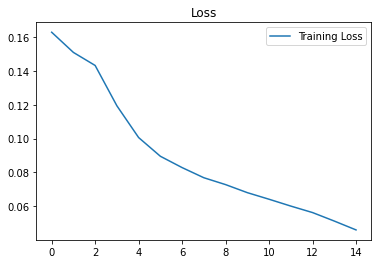

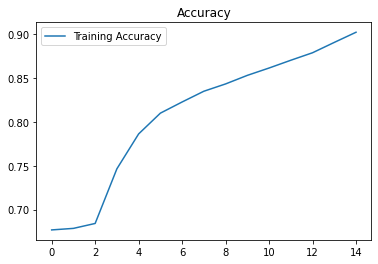

In [ ]:
history = history.history
plot_metrics(history)

In [ ]:
model=load_model(filepath="/content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5")
EPOCHS=2
checkpoint_path = "/content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,monitor="accuracy", verbose=1, save_best_only=True, mode='auto',save_freq="epoch")
training_generator=DataGenerator(list_ids)
model.fit(training_generator,epochs=EPOCHS,callbacks=[checkpoint])

Epoch 1/2
499/499 [==============================] - 1324s 3s/step - loss: 0.0296 - accuracy: 0.9391

Epoch 00001: accuracy improved from -inf to 0.93911, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5
Epoch 2/2
499/499 [==============================] - 223s 448ms/step - loss: 0.0273 - accuracy: 0.9441

Epoch 00002: accuracy improved from 0.93911 to 0.94412, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5


In [ ]:
# history = model.history.history
# plot_metrics(history)
model=load_model("/content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5")
model.fit(training_generator,epochs=EPOCHS,callbacks=[checkpoint])

Epoch 1/2
499/499 [==============================] - 223s 446ms/step - loss: 0.0245 - accuracy: 0.9500

Epoch 00001: accuracy improved from 0.94412 to 0.95002, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5
Epoch 2/2
499/499 [==============================] - 222s 446ms/step - loss: 0.0231 - accuracy: 0.9531

Epoch 00002: accuracy improved from 0.95002 to 0.95310, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5


In [ ]:
model.fit(training_generator,epochs=3,callbacks=[checkpoint])

Epoch 1/3
499/499 [==============================] - 222s 445ms/step - loss: 0.0216 - accuracy: 0.9563

Epoch 00001: accuracy improved from 0.95310 to 0.95627, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5
Epoch 2/3
499/499 [==============================] - 223s 445ms/step - loss: 0.0205 - accuracy: 0.9586

Epoch 00002: accuracy improved from 0.95627 to 0.95859, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5
Epoch 3/3
499/499 [==============================] - 222s 445ms/step - loss: 0.0196 - accuracy: 0.9605

Epoch 00003: accuracy improved from 0.95859 to 0.96053, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5


In [ ]:
model=load_model("/content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5")
model.fit(training_generator,epochs=5,callbacks=[checkpoint])

Epoch 1/5
499/499 [==============================] - 223s 446ms/step - loss: 0.0187 - accuracy: 0.9625

Epoch 00001: accuracy improved from 0.96053 to 0.96254, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5
Epoch 2/5
499/499 [==============================] - 222s 445ms/step - loss: 0.0177 - accuracy: 0.9645

Epoch 00002: accuracy improved from 0.96254 to 0.96448, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5
Epoch 3/5
499/499 [==============================] - 222s 446ms/step - loss: 0.0168 - accuracy: 0.9665

Epoch 00003: accuracy improved from 0.96448 to 0.96654, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5
Epoch 4/5
499/499 [==============================] - 223s 446ms/step - loss: 0.0166 - accuracy: 0.9670

Epoch 00004: accuracy improved from 0.96654 to 0.96705, saving model to /content/drive/MyDrive/U-net/drop_check/weig

In [ ]:
EPOCHS = 5
model=load_model("/content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001.h5")
checkpoint_path = "/content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001_epoch_30_.{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,monitor="accuracy", verbose=1, save_best_only=True, mode='auto',save_freq="epoch")
history=model.fit(training_generator,epochs=EPOCHS,callbacks=[checkpoint])

Epoch 1/5
499/499 [==============================] - 223s 445ms/step - loss: 0.0156 - accuracy: 0.9691

Epoch 00001: accuracy improved from -inf to 0.96910, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001_epoch_30_.01.h5
Epoch 2/5
499/499 [==============================] - 222s 445ms/step - loss: 0.0161 - accuracy: 0.9683

Epoch 00002: accuracy did not improve from 0.96910
Epoch 3/5
499/499 [==============================] - 222s 445ms/step - loss: 0.0143 - accuracy: 0.9719

Epoch 00003: accuracy improved from 0.96910 to 0.97189, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001_epoch_30_.03.h5
Epoch 4/5
499/499 [==============================] - 222s 445ms/step - loss: 0.0137 - accuracy: 0.9731

Epoch 00004: accuracy improved from 0.97189 to 0.97311, saving model to /content/drive/MyDrive/U-net/drop_check/weights-no-drop-1999-learnignrate_0.0001_epoch_30_.04.h5
Epoch 5/5
499/499 [==========

['1012675629_2',
 '100032540_1',
 '1018882799_1',
 '1019068877_1',
 '1021890651_1',
 '1033312112_1',
 '103770709_1',
 '1030333538_1',
 '1050957686_1',
 '103887554_1',
 '106348540_1',
 '1063957157_1',
 '1050957686_2',
 '107473045_1',
 '111168419_1',
 '109172267_1',
 '111247636_1',
 '107635070_1',
 '109209934_1',
 '1111575413_1',
 '1144216773_1',
 '1125456779_1',
 '1115234911_1',
 '1124465440_1',
 '114530171_1',
 '114501272_1',
 '1156177278_1',
 '11564757_2',
 '1163855977_1',
 '1166270350_1',
 '1167462532_1',
 '118736733_2',
 '118471529_1',
 '118736733_1',
 '117932364_1',
 '1195037433_1',
 '118736828_1',
 '1207662328_2',
 '120801881_1',
 '122276700_1',
 '1227072121_1',
 '1208068331_1',
 '1238488784_1',
 '1240101737_1',
 '1240746154_1',
 '1252885598_1',
 '1265969136_1',
 '1259817140_1',
 '126229661_1',
 '1266283652_1',
 '128244378_1',
 '127567332_1',
 '1269816217_1',
 '126968967_1',
 '1297446285_1',
 '130625688_1',
 '131437823_1',
 '131787989_1',
 '1336365736_1',
 '13601661_1',
 '13443049

In [ ]:
test_image=load_image2("1012675629_2_image.jpg")
test_label=load_label2("1012675629_2_label.png")
xx=[]
yy=[]

xx.append(test_image)
xx=np.array(xx)

yy.append(test_label)
yy=to_categorical(yy,11)

In [ ]:
model.evaluate(xx,yy)

1/1 [==============================] - 0s 63ms/step - loss: 9.4776 - accuracy: 0.2676


[9.477569580078125, 0.2675563395023346]

In [ ]:
pre=model.predict(xx)

In [ ]:
pre=np.argmax(pre,axis=3)

In [ ]:
np.unique(pre)

array([ 0,  1,  6,  9, 10])